In [1]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
from collections import defaultdict


In [2]:
def get_results(filename):
    with open(filename, "rb") as file:
        results = pickle.load(file)

    rolled_up = []
    for result in results:
        r = pd.Series(result).rolling(200, min_periods=1).mean().dropna()
        rolled_up.append(r)
    rolled_up = np.array(rolled_up)

    avg_rewards = rolled_up.mean(0)
    min_rewards = rolled_up.min(0)
    max_rewards = rolled_up.max(0)
    std_rewards = rolled_up.std(0)

    bot = np.maximum(avg_rewards - std_rewards, min_rewards)
    top = np.minimum(avg_rewards + std_rewards, max_rewards)
    return avg_rewards, bot, top


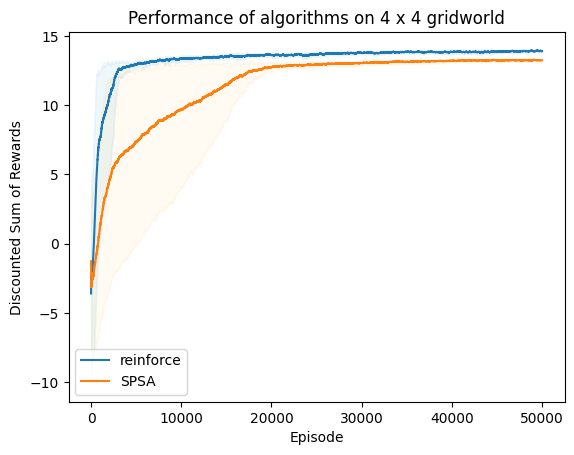

In [3]:
avg_rewards, bot, top = get_results("reinforce_results.pkl")
plt.plot(avg_rewards, label="reinforce")
plt.fill_between(range(len(avg_rewards)), bot, top, color='lightblue', alpha=0.2)


avg_rewards, bot, top = get_results("spsa_results.pkl")
plt.plot(avg_rewards, label="SPSA")
plt.fill_between(range(len(avg_rewards)), bot, top, color='orange', alpha=0.05)


plt.xlabel('Episode')
plt.ylabel('Discounted Sum of Rewards')
plt.title('Performance of algorithms on 4 x 4 gridworld')
plt.legend()
plt.show()


In [4]:
vals = defaultdict(int)
for seed in range(10):
    # print(seed)
    with open(f"saves/reinforce/weights.{seed}.pth", 'rb') as file:
        state_dict = torch.load(file)
    for key, value in state_dict.items():
        # print("\t", key, value.max(), value.min())
        vals[key+".max"] = max(vals[key+".max"], value.max().item())
        vals[key+".min"] = min(vals[key+".min"], value.min().item())

print("Reinforce")
for key, value in vals.items():
    print(key, value)


Reinforce
fc.weight.max 0.5898380875587463
fc.weight.min -0.7791681289672852
fc.bias.max 0.8417656421661377
fc.bias.min -0.7802666425704956


In [5]:
vals = defaultdict(int)
for seed in range(10):
    # print(seed)
    with open(f"saves/spsa/weights.seed={seed}.num_trails=10.pth", 'rb') as file:
        state_dict = torch.load(file)
    for key, value in state_dict.items():
        vals[key+".max"] = max(vals[key+".max"], value.max().item())
        vals[key+".min"] = min(vals[key+".min"], value.min().item())

print("SPSA")
for key, value in vals.items():
    print(key, value)


SPSA
fc.weight.max 0.5925906300544739
fc.weight.min -0.4846600592136383
fc.bias.max 0.593832790851593
fc.bias.min -0.43805211782455444


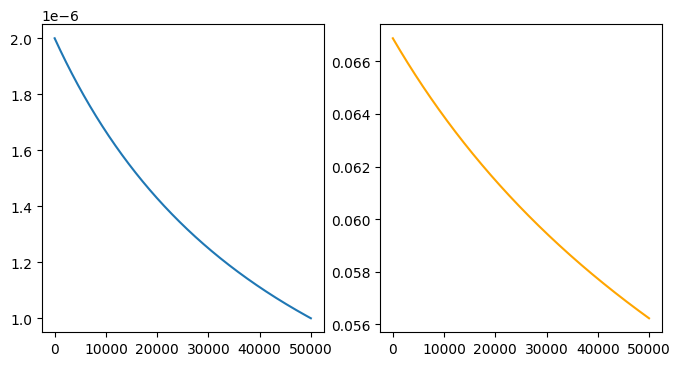

In [6]:
def get_delta(episode):
    return (2e-5 / (1 + episode * 2e-5)) ** 0.25


def get_alpha(episode):
    return 2e-6 / (1 + episode * 2e-5)


episode = np.arange(50000)
alpha = get_alpha(episode)
delta = get_delta(episode)

fig, ax = plt.subplots(1, 2, figsize=(8, 4))
ax[0].plot(episode, alpha)
ax[1].plot(episode, delta, color="orange")
